In [1]:
# Stage 1: Collect Explore
# Stage 2: Annotate and convert labelme annotations to seg
# Stage 3: Find spawn location and target for reexplore (reexplore_data.json)
# Stage 4: Run reexplore for all objects, one at a time 
# Stage 5: Run label prop
# Stage 6: Run training 

In [2]:
# from droidlet.dashboard.o3dviz import O3DViz
# o3dviz = O3DViz(True)
# o3dviz.start()

In [3]:
# Stage 1: Collect Explore to $HOME/explore_data

# Stage 3: Find spawn location and target for reexplore (reexplore_data.json) in a separate out_dir


obj_dir /home/locobotm/0512_data/reexplore_data_0512_3/4
saving propagated frames to /home/locobotm/0512_data/reexplore_data_0512_3/4/c1pp/pred
height 480 width 640
uv_one_in_cam.shape (3, 307200)
visualize_pcd shape (307200, 3)
src_pts_in_cur_cam.shape (307200, 3)
annot_img.shape (480, 640), src_label.shape (480, 640)
pts_in_cur_img.shape (307200, 3)
(480, 640) float32
type(semantic_obs) (640, 480)


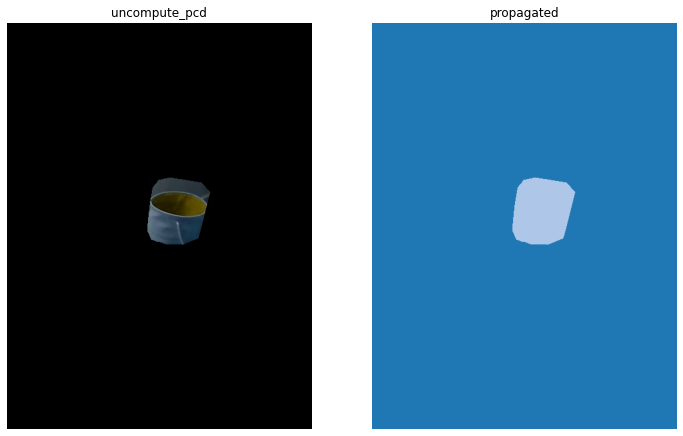

In [12]:
import os

# os.environ["WEBRTC_PORT"] = "9999"

"""
Copyright (c) Facebook, Inc. and its affiliates.
"""
import numpy as np
from droidlet.lowlevel.robot_mover_utils import transform_pose
from droidlet.shared_data_structs import RGBDepth
from droidlet.lowlevel.hello_robot.rotation import (
    rotation_matrix_x,
    rotation_matrix_y,
    rotation_matrix_z,
)
import cv2
import math
from numba import njit
from math import ceil, floor, isnan
from collections import deque, defaultdict

d3_40_colors_rgb: np.ndarray = np.array(
    [
        [31, 119, 180],
        [174, 199, 232],
        [255, 127, 14],
        [255, 187, 120],
        [44, 160, 44],
        [152, 223, 138],
        [214, 39, 40],
        [255, 152, 150],
        [148, 103, 189],
        [197, 176, 213],
        [140, 86, 75],
        [196, 156, 148],
        [227, 119, 194],
        [247, 182, 210],
        [127, 127, 127],
        [199, 199, 199],
        [188, 189, 34],
        [219, 219, 141],
        [23, 190, 207],
        [158, 218, 229],
        [57, 59, 121],
        [82, 84, 163],
        [107, 110, 207],
        [156, 158, 222],
        [99, 121, 57],
        [140, 162, 82],
        [181, 207, 107],
        [206, 219, 156],
        [140, 109, 49],
        [189, 158, 57],
        [231, 186, 82],
        [231, 203, 148],
        [132, 60, 57],
        [173, 73, 74],
        [214, 97, 107],
        [231, 150, 156],
        [123, 65, 115],
        [165, 81, 148],
        [206, 109, 189],
        [222, 158, 214],
    ],
    dtype=np.uint8,
) 

# Values for locobot in habitat. 
# TODO: generalize this for all robots
fx, fy = 256, 256
cx, cy = 256, 256

#locoboot
# intrinsic_mat = np.array([[  fx, 0., cx],
#                             [  0., fy, cy],
#                             [  0., 0., 1.]])

intrinsic_mat = np.array(
    [[604.50262451,   0.        , 312.43200684],
       [  0.        , 604.22351074, 236.35299683],
       [  0.        ,   0.        ,   1.        ]]
)

# fx, fy = 605.2880249, 605.65637207
# cx, cy = 319.11114502, 239.48382568
# intrinsic_mat = np.array([[  fx, 0., cx],
#                             [  0., fy, cy],
#                             [  0., 0., 1.]])

# rotation from pyrobot to canonical coordinates (https://github.com/facebookresearch/fairo/blob/main/agents/locobot/coordinates.MD)
# rot = np.array([[0.0, 0.0, 1.0], [-1.0, 0.0, 0.0], [0.0, -1.0, 0.0]])
# CAMERA_HEIGHT = 0.6
# trans = np.array([0, 0, CAMERA_HEIGHT])

# my hello
# trans = np.array([ 0.03492126, -0.01123962,  1.24354383])

# rot = np.array([[ 0.84003093,  0.53898409, -0.06200145],
#  [-0.04361892, -0.04681613, -0.99795072],
#  [-0.54078223,  0.84101391, -0.01581709]])

# soumith
trans = np.array([0.02283596, 0.01864796, 1.25382417])
rot = np.array([
    [0.86391456, 0.49976488, 0.06234341],
    [0.05324502, 0.03236112, -0.99805373],
    [-0.50081594, 0.86555262, 0.00143363]
])


 # TODO: Consolidate camera intrinsics and their associated utils across locobot and habitat.
def compute_uvone(height, width):
    intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
    img_resolution = (height, width)
    img_pixs = np.mgrid[0 : img_resolution[0] : 1, 0 : img_resolution[1] : 1]
    img_pixs = img_pixs.reshape(2, -1)
    img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
    uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
    uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)
    return uv_one_in_cam, intrinsic_mat, rot, trans

# def compute_uvone(intrinsic_mat, height, width):
#     intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
#     img_pixs = np.mgrid[0:height:1, 0:width:1]
#     img_pixs = img_pixs.reshape(2, -1)
#     img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
#     uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
#     uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)
#     return uv_one_in_cam

def uncompute_pcd(pts, rot_cam, trans_cam, base_state, intrinsic_mat):
    translation_vector = np.array(
        [trans_cam[0] + base_state[0], trans_cam[1] + base_state[1], trans_cam[2] + 0]
    ).reshape(-1)
    h, w = pts.shape[0], pts.shape[1]

    pts = pts - translation_vector

    roty90, rotxn90 = rotation_matrix_y(90), rotation_matrix_x(-90)
    rot_base = rotation_matrix_z(math.degrees(base_state[2]))

    rotation_matrix = rot_base @ rot_cam @ rotxn90 @ roty90
    pts = np.dot(pts, np.linalg.inv(rotation_matrix).T)

    #################################################################
    pts = np.matmul(intrinsic_mat, pts.reshape(-1, 3).T).T
    pts[:, 0:2] /= pts[:, [2]]
    pts = pts.reshape(h*w, 3)
    return pts


def compute_pcd(rgb, depth, rot_cam, trans_cam, base_state, uv_one_in_cam):
        rgb = np.asarray(rgb).astype(np.uint8)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

        depth = depth.astype(np.float32)

        # the realsense pointcloud seems to produce some spurious points
        # really far away. So, limit the depth to 8 metres
        thres = 8000
        depth[depth > thres] = thres

        depth_copy = np.copy(depth)

        depth = depth.reshape(rgb.shape[0] * rgb.shape[1])

        # normalize by the camera's intrinsic matrix
        pts_in_cam = np.multiply(uv_one_in_cam, depth)
        pts = pts_in_cam.T

        # Now, the points are in camera frame.
        # In camera frame
        # z is positive into the camera
        # (larger the z, more into the camera)
        # x is positive to the right
        # (larger the x, more right of the origin)
        # y is positive to the bottom
        # (larger the y, more to the bottom of the origin)
        #                                 /
        #                                /
        #                               / z-axis
        #                              /
        #                             /_____________ x-axis (640)
        #                             |
        #                             |
        #                             | y-axis (480)
        #                             |
        #                             |

        # We now need to transform this to pyrobot frame, where
        # x is into the camera, y is positive to the left,
        # z is positive upwards
        # https://pyrobot.org/docs/navigation
        #                            |    /
        #                 z-axis     |   /
        #                            |  / x-axis
        #                            | /
        #  y-axis        ____________|/
        #
        # If you hold the first configuration in your right hand, and
        # visualize the transformations needed to get to the second
        # configuration, you'll see that
        # you have to rotate 90 degrees anti-clockwise around the y axis, and then
        # 90 degrees clockwise around the x axis.
        # This results in the final configuration
        roty90 = rotation_matrix_y(90)
        rotxn90 = rotation_matrix_x(-90)
        # next, rotate and translate pts by
        # the robot pose and location
        rot_base = rotation_matrix_z(math.degrees(base_state[2]))

        rotation_matrix = rot_base @ rot_cam @ rotxn90 @ roty90  
        translation_vector = np.array(
            [trans_cam[0] + base_state[0], trans_cam[1] + base_state[1], trans_cam[2] + 0]
        ).reshape(-1)

        pts = np.dot(pts, rotation_matrix.T)
        pts = pts + translation_vector

        # now rewrite the ordering of pts so that the colors (rgb_rotated)
        # match the indices of pts
        # pts = pts.reshape((rgb.shape[0], rgb.shape[1], 3))
        # pts = np.rot90(pts, k=1, axes=(1, 0))
        # pts = pts.reshape(rgb.shape[0] * rgb.shape[1], 3)

        # depth_rotated = np.rot90(depth_copy, k=1, axes=(1, 0))
        # rgb_rotated = np.rot90(rgb, k=1, axes=(1, 0))

        # return RGBDepth(rgb_rotated, depth_rotated, pts)
        return pts

def convert_depth_to_pcd(depth, pose, uv_one_in_cam, rot, trans):
    # point cloud in camera frame
    depth = (depth.astype(np.float32) / 1000.0).reshape(-1)
    pts_in_cam = np.multiply(uv_one_in_cam, depth)
    pts_in_cam = np.concatenate((pts_in_cam, np.ones((1, pts_in_cam.shape[1]))), axis=0)
    # point cloud in robot base frame
    pts_in_base = pts_in_cam[:3, :].T
    pts_in_base = np.dot(pts_in_base, rot.T)
    pts_in_base = pts_in_base + trans.reshape(-1)
    # point cloud in world frame (pyrobot)
    pts_in_world = transform_pose(pts_in_base, pose)
    return pts_in_world

# @njit
def get_annot(height, width, pts_in_cur_img, src_pts_in_cur_cam, cur_pts_in_cur_cam, src_label, valid_z):
    """
    This creates the new semantic labels of the projected points in the current image frame. Each new semantic label is the 
    semantic label corresponding to pts_in_cur_img in src_label. 
    """
    annot_img = np.zeros((height, width)).astype(np.float32)
    print(f'annot_img.shape {annot_img.shape}, src_label.shape {src_label.shape}')
    print(f'pts_in_cur_img.shape {pts_in_cur_img.shape}')
    for indx in range(len(pts_in_cur_img)):
        r = int(indx/width)
        c = int(indx - r*width)
        x, y, _ = pts_in_cur_img[indx]
        # We take ceil and floor combinations to fix quantization errors
        if not isnan(x) and not isnan(y) and (
            floor(x) >= 0 and ceil(x) < width and floor(y) >=0 and ceil(y) < height
        ):# and valid_z[indx]:
            cur_indx = ceil(x) + ceil(y) * width
            try:
                # if src_pts_in_cur_cam[indx][2] - cur_pts_in_cur_cam[cur_indx][2] < 0.1:
                annot_img[ceil(y)][ceil(x)] = src_label[r][c]
                annot_img[floor(y)][floor(x)] = src_label[r][c]
                annot_img[ceil(y)][floor(x)] = src_label[r][c]
                annot_img[floor(y)][ceil(x)] = src_label[r][c]
            except Exception as ex:
                print(f'caught exception {ex}')
                print(f'r c x y {r, c, x, y}')
                raise ex
    return annot_img
    def closest_non_zero(a, x, y):
        h, w = len(a), len(a[0])
        def get_neighbors(a, curx, cury):
            ns = []
            if curx > 0:
                ns.append((curx-1, cury)) # n
            if cury > 0:
                ns.append((curx, cury-1)) # w
            if cury < w-1:
                ns.append((curx, cury+1)) # e 
            if curx < h-1:
                ns.append((curx+1, cury)) # s
            if curx > 0 and cury > 0:
                ns.append((curx-1, cury-1)) #nw
            if curx > 0 and cury < w-1:
                ns.append((curx-1, cury+1)) #ne
            if curx < h-1 and cury < w-1:
                ns.append((curx+1, cury+1)) #se
            if curx < h-1 and cury > 0:
                ns.append((curx+1, cury-1)) #sw 
            return ns

        bfsq = deque([])
        visited = np.zeros_like(a)
        bfsq.append((x,y))
        pop_count = 0
        push_count = 1
        while len(bfsq) > 0:
            curx, cury = bfsq.popleft()
            pop_count += 1
            # if pop_count % 100 == 0:
                # print(f'pop_count {pop_count}')
            visited[curx][cury] = 1
            if a[curx][cury] > 0:
                return a[curx][cury]
            if push_count < 8:
                ns = get_neighbors(a, curx, cury)
                for n in ns:
                    try:
                        if visited[n] == 0:
                            push_count += 1
                            bfsq.append(n)
                    except Exception as ex:
                        print(f'exception {ex} for n {n}')
                        raise ex
        # print(f'no nearest neighbor found after {pop_count} lookups! ...')
        return 0

    def max_vote(annot_img, x, y):
        kernel_size = 5
        votes = defaultdict(int)
        for i in range(x-kernel_size, x+kernel_size):
            for j in range(y-kernel_size, y+kernel_size):
                if i >=0 and i < 512 and j > 0 and j < 512:
                    v = annot_img[i][j]
                    votes[v] += 1
        return max(votes, key=votes.get)
    
    import random
    import time
    
    def do_nn_fill(annot_img):
        print(f'doing nn fill ...')
        start = time.time()
        print(f'zeros {np.sum(annot_img == 0)}')
        for x in range(len(annot_img)):
            for y in range(len(annot_img[0])):
                if annot_img[x][y] == 0:# and random.randint(1,2) == 1:
                    annot_img[x][y] = closest_non_zero(annot_img, x, y)
                    # annot_img[x][y] = max_vote(annot_img, x, y)
        end = time.time()
        print(f'took {end - start} seconds.')
        return annot_img
    
    return do_nn_fill(annot_img)

def vis_pcd(points, colors, base_state):
    points, colors = points.reshape(-1, 3), colors.reshape(-1, 3)
    colors = colors / 255.

   
    opcd = o3d.geometry.PointCloud()
    opcd.points = o3d.utility.Vector3dVector(points)
    opcd.colors = o3d.utility.Vector3dVector(colors)
#     opcd = opcd.voxel_down_sample(0.03)

    points = np.asarray(opcd.points)
    colors = np.asarray(opcd.colors)

    o3dviz.put('pointcloud', opcd)
    
    x, y, yaw = base_state
    o3dviz.add_robot(base_state, 1.41)


import open3d as o3d

def visualize_pcd(rgb, xyz, base_state):
    
    print(f'visualize_pcd shape {xyz.shape}')
    # Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
    
    colors = rgb.reshape(-1, 3)
    colors = colors / 255.
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz/1000.)
    pcd.colors = o3d.utility.Vector3dVector(colors)
#     o3d.visualization.draw_geometries( [pcd])
    
    
    viewer = o3d.visualization.Visualizer()
    viewer.create_window()
    v = viewer.get_view_control()
    opt = viewer.get_render_option()
    opt.show_coordinate_frame = True
  
    
    look_at = np.array([1, 0, 0])  # look at x positive
    cam_pos = [-5, 0, 1]  # 5 cm behind origin
    y_axis = np.array([0, 0, 1])  # y axis is z-inward
    v.set_lookat(look_at) 
    v.set_up(y_axis)
    v.
    
    # viewer.scene.camera.look_at(look_at, cam_pos, y_axis)
    

    # viewer.add_geometry(pcd)
#     viewer

    
    
#     print(f'visualize_pcd base_state {base_state}')
    x, y, yaw = [0., 0., 0.] # base_state

    robot_orientation = o3d.geometry.TriangleMesh.create_arrow(cylinder_radius=.05,
                                                       cone_radius=.075,
                                                       cylinder_height = .50,
                                                       cone_height = .4,
                                                       resolution=20)
    robot_orientation.compute_vertex_normals()
    robot_orientation.paint_uniform_color([1.0, 0.5, 0.1])

    robot_orientation.translate([x, y, 0.], relative=False)
    # make the cylinder representing the robot to be parallel to the floor
    robot_orientation.rotate(o3d.geometry.get_rotation_matrix_from_axis_angle([0, math.pi/2, 0]))
    # rotate the cylinder by the robot orientation
    if yaw != 0:
        robot_orientation.rotate(o3d.geometry.get_rotation_matrix_from_axis_angle([0, 0, yaw]))

    viewer.add_geometry(robot_orientation)
    # viewer.add_geometry(pcd)
    
    viewer.run()
    viewer.destroy_window()

    
#     o3d.io.write_point_cloud("TestData/sync.ply", pcd)

#     # Load saved point cloud and visualize it
#     pcd_load = o3d.io.read_point_cloud("TestData/sync.ply")
#     o3d.visualization.draw_geometries([pcd_load])

#     # convert Open3D.o3d.geometry.PointCloud to numpy array
#     xyz_load = np.asarray(pcd_load.points)
#     print('xyz_load')
#     print(xyz_load)

#     # save z_norm as an image (change [0,1] range to [0,255] range with uint8 type)
#     img = o3d.geometry.Image((z_norm * 255).astype(np.uint8))
#     o3d.io.write_image("TestData/sync.png", img)
#     o3d.visualization.draw_geometries([img])

class LabelPropagate:
    def __call__(self,    
        src_img,
        src_depth,
        src_label,
        src_pose,
        cur_pose,
        cur_depth,
    ):
        """
        1. Gets point cloud for the source image 
        2. Transpose the point cloud based on robot location (cur_pose) 
        3. Project the point cloud back into the image frame. The corresponding semantic label for each point from the src_label becomes
        the new semantic label in the current frame.
        Args:
            src_img (np.ndarray): source image to propagte from
            src_depth (np.ndarray): source depth to propagte from
            src_label (np.ndarray): source semantic map to propagte from
            src_pose (np.ndarray): (x,y,theta) of the source image
            cur_pose (np.ndarray): (x,y,theta) of current image
            cur_depth (np.ndarray): current depth
        """
        # Everything assumes image is still vertical

        height, width, _ = src_img.shape
        print(f'height {height} width {width}')
        uv_one_in_cam, intrinsic_mat, rot, trans = compute_uvone(height, width) #640, 480)
        print(f'uv_one_in_cam.shape {uv_one_in_cam.shape}')

        src_pts_in_world = compute_pcd(src_img, src_depth, rot, trans, src_pose, uv_one_in_cam)
        
        #looks right
        
#         src_pts_in_world = src_pcd.reshape(height*width, 3) #
#         src_pts_in_world = convert_depth_to_pcd(src_depth, src_pose, uv_one_in_cam, rot, trans)
        
        # visualize using o3d
        visualize_pcd(src_img, src_pts_in_world, src_pose)
        # vis_pcd(src_pts_in_world, src_img, src_pose)
        
#         # convert pts_in_world to current base
#         src_pts_in_cur_base = transform_pose(src_pts_in_world, (-cur_pose[0], -cur_pose[1], 0))
#         src_pts_in_cur_base = transform_pose(src_pts_in_cur_base, (0.0, 0.0, -cur_pose[2]))
            
#         # conver point from current base to current camera frame
#         src_pts_in_cur_cam = src_pts_in_cur_base - trans.reshape(-1)
#         src_pts_in_cur_cam = np.dot(src_pts_in_cur_cam, rot)
        
#         # Get Valid Z
        valid_z = None # src_pts_in_cur_cam[:,2] > 0
        
        # Filter based on current depth.
        # cur_depth = (cur_depth.astype(np.float32) / 1000.0).reshape(-1)
        # cur_pts_in_cur_cam = np.multiply(uv_one_in_cam, cur_depth).T 
        
        # conver pts in current camera frame into 2D pix values
#         src_pts_in_cur_img = np.matmul(intrinsic_mat, src_pts_in_cur_cam.T).T        
#         src_pts_in_cur_img /= src_pts_in_cur_img[:, 2].reshape([-1, 1])

#         rgbd = RGBDepth(src_img, cur_depth, src_pts_in_cur_cam)

        
        print(f'src_pts_in_cur_cam.shape {src_pts_in_world.shape}')
        
        src_pts_in_cur_img = uncompute_pcd(src_pts_in_world.reshape(src_img.shape), rot, trans, cur_pose, intrinsic_mat)
        
        return get_annot(height, width, src_pts_in_cur_img, None, None, src_label, valid_z)



# Stage 5: Run label prop
# Ensure reex_dir has all objects reexplored

# reex_dir = '/home/locobotm/explore_data/default/0/reexplore/'
# explore_dir = '/home/locobotm/explore_data/default/0/'

# soumiths data
reex_dir = '/home/locobotm/0512_data/reexplore_data_0512_3/'
explore_dir = '/home/locobotm/home2_data/0'

# load reex json
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
# from droidlet.perception.robot import LabelPropagate
from PIL import Image

def save_propagated_visual(cur_img, semantic2, save_dir, out_indx):
    
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
        
    cur_img = np.rot90(cur_img, k=1, axes=(1, 0))
    semantic2 = np.rot90(semantic2, k=1, axes=(1, 0))

    arr = [cur_img]
    # arr.append(semantic1[0].reshape(480, 640))
    # arr.append(
    for semantic_obs in [semantic2]:
        print(f'type(semantic_obs) {semantic_obs.shape}')
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)

    titles = ['uncompute_pcd', 'propagated']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 2, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
#     plt.savefig("{}/{:05d}.jpg".format(save_dir, out_indx))
    plt.show()


reex_json = os.path.join(reex_dir, 'reexplore_data.json')
with open(reex_json, 'r') as f:
    reex_data = json.load(f)

lp = LabelPropagate()
    
for reex_id in ['4']: #reex_data.keys():
    obj_dir = os.path.join(reex_dir, reex_id)
    obj_data = reex_data[reex_id]
    print(f'obj_dir {obj_dir}')
    src_img_indx = obj_data['src_img_id']
    # for each examine heuristic
    
    # load src_img_id rgb, label and pose
    src_img = cv2.imread(os.path.join(explore_dir, "rgb/{:05d}.jpg".format(src_img_indx)))
    src_depth = np.load(os.path.join(explore_dir, "depth/{:05d}.npy".format(src_img_indx)))
    src_pcd = np.load(os.path.join(explore_dir, "pcd/{:05d}.npy".format(src_img_indx)))
    src_label = np.load(os.path.join(explore_dir, "seg/{:05d}.npy".format(src_img_indx)))
    
    src_label = np.rot90(src_label, k=-1, axes=(1, 0))
    src_depth = np.rot90(src_depth, k=-1, axes=(1, 0))
    src_img = np.rot90(src_img, k=-1, axes=(1, 0))
    
    with open(os.path.join(explore_dir, 'data.json'), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(src_img_indx)]
    
    # for each heuristic, for each image in rgb, propagate 
    for heu in ['c1pp']:
        heu_dir = os.path.join(obj_dir, heu)
        prop_dir = os.path.join(heu_dir, 'pred')
        print(f'saving propagated frames to {prop_dir}')
        os.makedirs(prop_dir, exist_ok=True)

        num_samples = min(len(os.listdir(os.path.join(heu_dir, 'rgb'))), 18)
        with open(os.path.join(heu_dir, 'data.json'), "r") as f:
            cur_pose_data = json.load(f) 

        for p in range(0, num_samples, 10):
            cur_pose = cur_pose_data[str(p)]
            cur_depth = np.load(os.path.join(heu_dir, "depth/{:05d}.npy".format(p)))    
            cur_img = cv2.imread(os.path.join(heu_dir, "rgb/{:05d}.jpg".format(p)))
            
            cur_depth = np.rot90(cur_depth, k=-1, axes=(1, 0))
            cur_img = np.rot90(cur_img, k=-1, axes=(1, 0))
            
            annot_img = lp(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)
#             annot_img = np.rot90(annot_img, k=1, axes=(1, 0))
            
            print(annot_img.shape, annot_img.dtype)
            mask = np.zeros(annot_img.shape[:2], dtype="uint8")
            mask[annot_img != 0] = True
            
            cur_img = cv2.bitwise_or(cur_img, cur_img, mask=mask)

            np.save(os.path.join(prop_dir, "{:05d}.npy".format(p)), annot_img.astype(np.uint32))
            save_propagated_visual(cur_img, annot_img, os.path.join(prop_dir, 'lp_visuals'), p)
            
            break
            
         #FIXME: also save the gt label

        
# TODO: combine all label prop for all objects in range(0,18,2) pred folders
# TODO: run coco and training on each pred folder
    

In [ ]:
921600/3

In [ ]:
640*480

In [ ]:
?o3d.visualization.draw_geometries

In [1]:
import open3d as o3d
o3d.visualization.webrtc_server.disable_http_handshake()
v = o3d.visualization.O3DVisualizer()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D WARNING] gui::Initialize() was not called


RuntimeError: [1;31m[Open3D Error] (void open3d::visualization::gui::Application::VerifyIsInitialized()) /root/Open3D/cpp/open3d/visualization/gui/Application.cpp:340: gui::Initialize() must be called before creating a window or UI element.
[0;m